In [1]:
import numpy as np
import math as math
import copy
import matplotlib.pyplot as plt
from sklearn import preprocessing 
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
import csv
import cv2
import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from scipy.integrate import quad
import sklearn

In [2]:
def integrand(x, k_y, r, m):
    return max( min( r*(x-(m/2.0)) + m/2.0, k_y + 1), k_y ) - k_y

def rotate(matrix, degree):
    degree = int(degree)
    if abs(degree) not in [0, 90, 180, 270, 360]:
        print("ERROR")
        assert(False)
    if degree == 0:
        return matrix
    elif degree > 0:
        return rotate(zip(*matrix[::-1]), degree-90)
    else:
        return rotate(zip(*matrix)[::-1], degree+90)

def primary_circle_weights(m, prim_circle_num):
    tot_angle=2*math.pi
    STD = .1
    list_weights = []
    for w in range(0, int(prim_circle_num)):
        M = np.zeros([int(m), int(m)])
        w = float(w)
        theta = w * (tot_angle) / prim_circle_num
        r = math.sin(theta) / math.cos(theta)

        for x_i in range(0, int(m)):
            for y_i in range(0, int(m)):
                I = quad(integrand, x_i, x_i+1, args=(y_i, r, m))
                sign = np.sign(r)
                if sign == 0: sign = 1
                A = sign * I[0]
                M[y_i, x_i] = A

        if theta > math.pi:
            M = list(rotate(list(rotate(M,90)), 90))
        
        M = np.array(M).flatten()
        M = M - np.mean(M)
        M = sklearn.preprocessing.normalize(np.array([M]), norm='l2', axis=1, copy=True, return_norm=False)[0]
        list_weights.append(M)

    Weights = np.array(list_weights)
    assert round(sum(Weights[0, :]) - 0, 3) == 0
    assert round(np.linalg.norm(Weights[0, :])- 1,3) == 0

    Weights = float(m) * float(STD) * Weights
    assert round(np.std(Weights[0, :])- STD,3) == 0
    assert round(np.std(Weights)- STD,3) == 0
    return Weights

In [3]:
# Rename the distances appropriately
def define_l2_distance(grid, center):
    for i, row in enumerate(grid):
        for j, item in enumerate(row):
            coord = np.absolute(np.subtract((i,j),center))
            grid[i,j] = max(coord)
    return grid

def define_distance(grid, center):
    for i, row in enumerate(grid):
        for j, item in enumerate(row):
            coord = np.subtract((i,j),center)            
            grid[i,j] = np.sqrt(np.sum(np.square(coord)))
    return grid

def define_cmg(rows, cols, nnd):
    center = math.floor(rows/2),math.floor(cols/2) # Floor because of 0-Index
    distance_grid = define_l2_distance(np.zeros([rows,cols]), center)
    perimeter_grid = distance_grid==np.max(distance_grid)

    convolutional_membership_grids = []
    for i, row in enumerate(perimeter_grid):
        for j, item in enumerate(row):
            if(item):
                grid_copy= ((define_distance(np.zeros([rows,cols]), (i,j))<=nnd)*1)*perimeter_grid
                convolutional_membership_grids.append(grid_copy)
    return convolutional_membership_grids

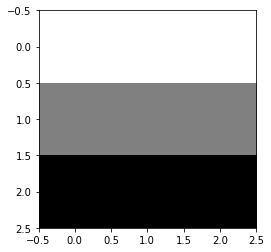

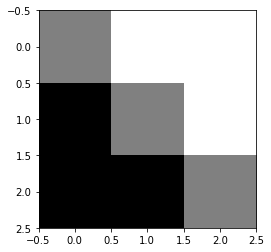

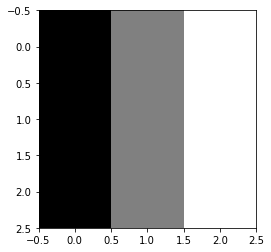

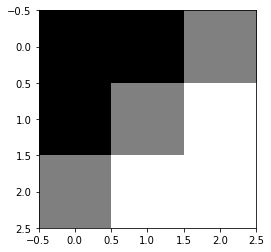

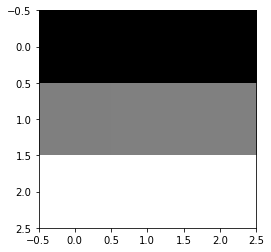

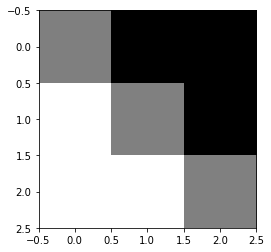

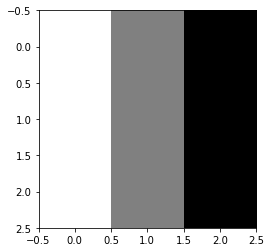

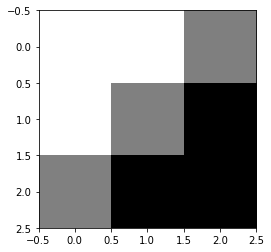

In [4]:
pcw = [g.reshape(3,3) for g in primary_circle_weights(3, 8)]
for w in pcw:
    plt.imshow(w.reshape(3,3), cmap='gray')
    plt.show()

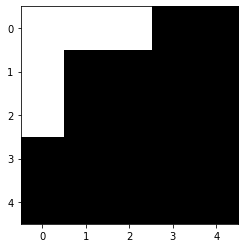

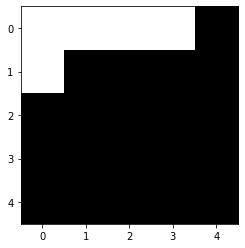

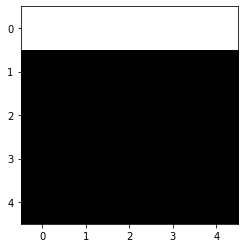

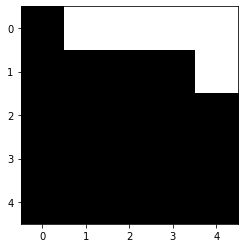

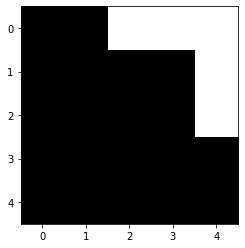

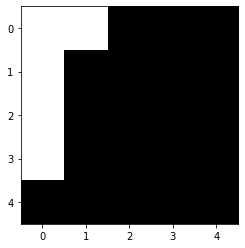

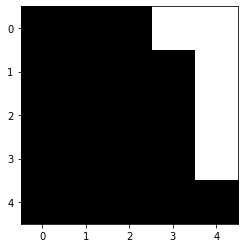

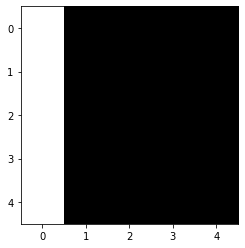

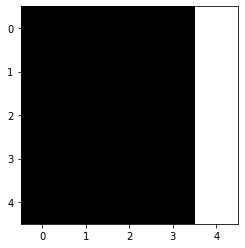

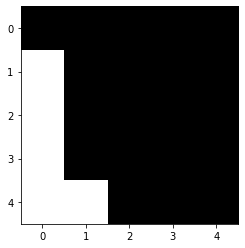

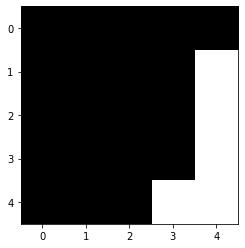

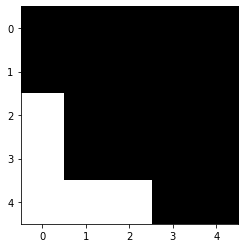

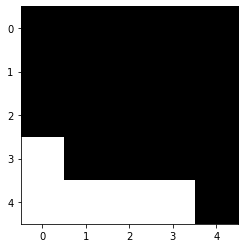

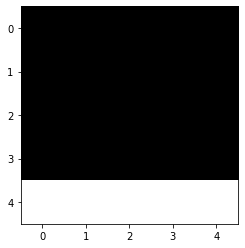

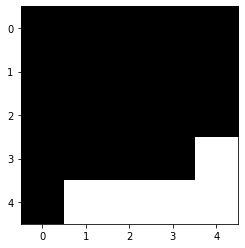

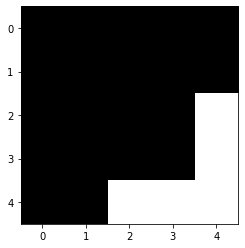

In [260]:
cmg = [g.reshape(5,5) for g in define_cmg(5, 5, 2)]
for w in cmg:
    plt.imshow(w, cmap='gray')
    plt.show()

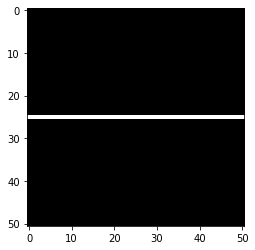

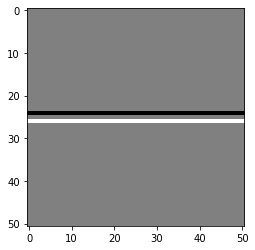

In [206]:
horizontal_line = np.zeros((51,51))
horizontal_line[25,:]=1
plt.imshow(horizontal_line, cmap='gray')
plt.show()
filtered_horizontal = cv2.filter2D(horizontal_line,-1,pcw[0])
plt.imshow(filtered_horizontal, cmap='gray')
plt.show()

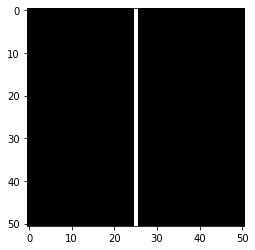

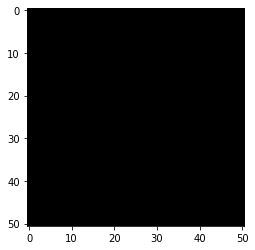

In [249]:
vertical_line = np.zeros((51,51))
vertical_line[:,25]=1
plt.imshow(vertical_line, cmap='gray')
plt.show()
filtered_verticle = cv2.filter2D(vertical_line,-1,pcw[0])
plt.imshow(filtered_verticle, cmap='gray')
plt.show()

In [208]:
circle = np.zeros((51,51))
center=(25,25)
for y, row in enumerate(circle):
    for x, item in enumerate(row):
        d = np.sqrt((y-center[1])**2 + (x-center[0])**2)
        if(d >= 10 and d < 11 ): circle[x,y]=1

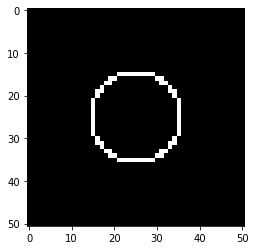

In [209]:
plt.imshow(circle, cmap='gray')
plt.show()

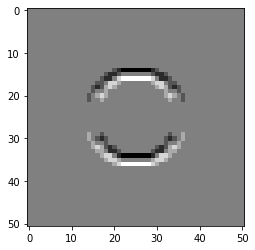

In [239]:
filtered_circle_hor = cv2.filter2D(circle,-1,pcw[0])
plt.imshow(filtered_circle_hor, cmap='gray')
plt.show()

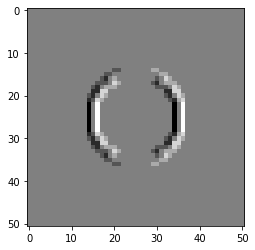

In [237]:
filtered_circle_vert = cv2.filter2D(circle,-1,pcw[6])
plt.imshow(filtered_circle_vert, cmap='gray')
plt.show()

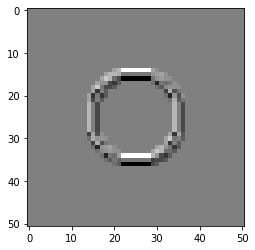

In [238]:
filtered_circle = np.zeros((51,51))
for g in pcw:
    filtered_circle = filtered_circle + cv2.filter2D(circle,-1,g)
plt.imshow(filtered_circle, cmap='gray') 
plt.show()

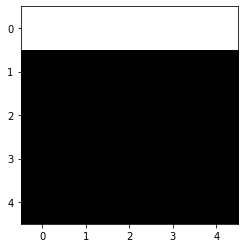

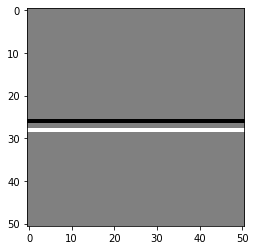

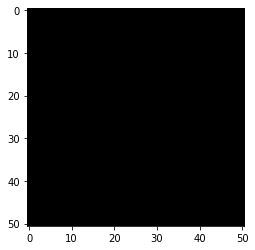

In [264]:
plt.imshow(cmg[2], cmap='gray')
plt.show()
filtered_horizontal_conv = cv2.filter2D(filtered_horizontal,-1,cmg[2])
plt.imshow(filtered_horizontal_conv, cmap='gray')
plt.show()
filtered_vertical_conv = cv2.filter2D(filtered_verticle,-1,cmg[2])
plt.imshow(filtered_verticle, cmap='gray')
plt.show()

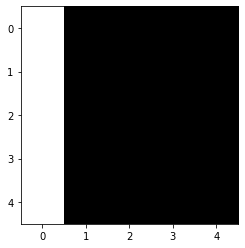

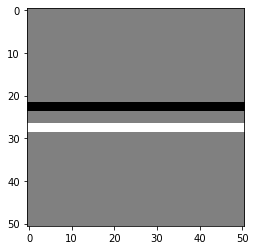

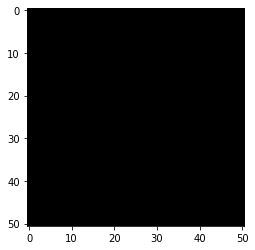

In [268]:
plt.imshow(cmg[7], cmap='gray')
plt.show()
filtered_horizontal_conv = cv2.filter2D(filtered_horizontal,-1,cmg[7])
plt.imshow(filtered_horizontal_conv, cmap='gray')
plt.show()
filtered_vertical_conv = cv2.filter2D(filtered_verticle,-1,cmg[7])
plt.imshow(filtered_verticle, cmap='gray')
plt.show()

In [646]:
batch_size = 10

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 1, 3)
        
        x= torch.randn(51,51).view(-1,1,51,51)
        self._to_linear = None
        self.convs(x)
        
        self.fc1 = nn.Linear(self._to_linear, 2)
        
    def convs(self, x):
        x = F.relu(self.conv1(x))
        
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
            
        return x
    
    def forward(self, x):
        # reshape inside of array
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = self.fc1(x)
        return F.softmax(x, dim=1)
    
def test(net):
    correct = 0 
    total = 0
    with torch.no_grad():
        for n in range(0,len(test_x),batch_size):
            data = test_x[n:n+batch_size]
            X = torch.tensor(data).to(device, dtype=torch.float).view(-1, 1, 51, 51)
            y = torch.tensor(test_y[n:n+batch_size]).to(device, dtype=torch.long)
            output = net(X)
            for idx, i in enumerate(output):
                if torch.argmax(i) == y[idx]: correct += 1
                total += 1
    return round(correct/total, 3)

In [647]:
oneSampleSize = 400
images = [vertical_line*np.random.rand(51,51) + np.random.rand(51,51)/2 for x in range(0,oneSampleSize)]
horizontal_lines = [horizontal_line*np.random.rand(51,51) + np.random.rand(51,51)/2 for x in range(0,oneSampleSize)]
images.extend(horizontal_lines)
images = np.array(images)
labels = [0]*oneSampleSize
labels.extend([1]*oneSampleSize)
labels = np.array(labels)
seq = np.arange(oneSampleSize*2)
np.random.shuffle(seq)
images = images[seq]
labels = labels[seq]

In [648]:
train_x , test_x , train_y , test_y = train_test_split(images , labels , 
                                            test_size = 0.2 ,
                                            random_state = 1)

In [649]:
net = Net().to(device)
optimizer = optim.SGD(net.parameters(), lr=1e-2)
results=[]
for e in range(5):
    for i in range(0,len(train_x),batch_size):
        data = train_x[i:i+batch_size]
        X=torch.tensor(data).to(device, dtype=torch.float).view(-1,1,51,51)
        y=torch.tensor(train_y[i:i+batch_size]).to(device, dtype=torch.long)
        net.zero_grad()
        output = net(X)
        loss = F.nll_loss(output, y)
        loss.backward()
        optimizer.step()
        results.append(test(net))

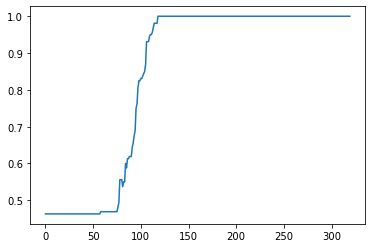

In [650]:
plt.plot(results)
plt.show()

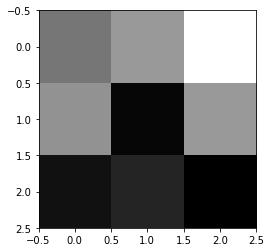

In [651]:
with torch.no_grad():
        for i,x in enumerate(net.conv1.weight):
            plt.imshow(np.array(x.cpu())[0], cmap='gray')
            plt.show()

In [655]:
net = Net().to(device)
optimizer = optim.SGD(net.parameters(), lr=1e-3)

with torch.no_grad():
    net.conv1.weight[0] = torch.nn.Parameter(torch.tensor(pcw[2])).to(device)
    #net.conv1.weight[1] = torch.nn.Parameter(torch.tensor(pcw[0])).to(device)
    
results=[]
for e in range(5):
    for i in range(0,len(train_x),batch_size):
        data = train_x[i:i+batch_size]
        X=torch.tensor(data).to(device, dtype=torch.float).view(-1,1,51,51)
        y=torch.tensor(train_y[i:i+batch_size]).to(device, dtype=torch.long)
        net.zero_grad()
        output = net(X)
        loss = F.nll_loss(output, y)
        loss.backward()
        optimizer.step()
        results.append(test(net))

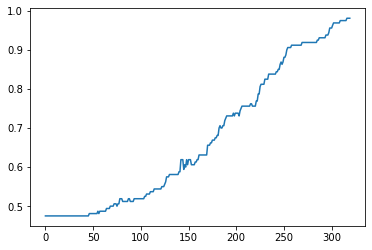

In [656]:
plt.plot(results)
plt.show()

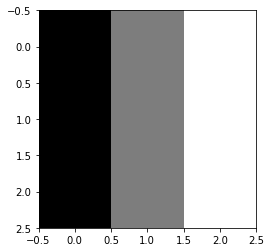

In [657]:
with torch.no_grad():
        for i,x in enumerate(net.conv1.weight):
            plt.imshow(np.array(x.cpu())[0], cmap='gray')
            plt.show()

In [637]:
cross = np.zeros((51,51))
for y, row in enumerate(cross):
    for x, item in enumerate(row):
        if(x>=y and x<=(y+1) and x>15 and x<=35): cross[x,y]=1
        if(x>=(-y+50) and x<=(-y+51) and x>15 and x<=35): cross[x,y]=1

In [638]:
oneSampleSize = 400
KAC = [circle*np.random.rand(51,51) + np.random.rand(51,51)/2 for x in range(0,oneSampleSize)]
horizontal_lines = [cross*np.random.rand(51,51) + np.random.rand(51,51)/2 for x in range(0,oneSampleSize)]
KAC.extend(horizontal_lines)
KAC = np.array(KAC)
labels = [0]*oneSampleSize
labels.extend([1]*oneSampleSize)
labels = np.array(labels)
seq = np.arange(oneSampleSize*2)
np.random.shuffle(seq)
KAC = KAC[seq]
labels = labels[seq]

In [644]:
KAC_train_x , KAC_test_x , KAC_train_y , KAC_test_y = train_test_split(KAC , labels , 
                                            test_size = 0.2 ,
                                            random_state = 1)

In [660]:
batch_size = 10

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, 3)
        
        x= torch.randn(51,51).view(-1,1,51,51)
        self._to_linear = None
        self.convs(x)
        
        self.fc1 = nn.Linear(self._to_linear, 2)
        
    def convs(self, x):
        x = F.relu(self.conv1(x))
        
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
            
        return x
    
    def forward(self, x):
        # reshape inside of array
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = self.fc1(x)
        return F.softmax(x, dim=1)
    
def test(net):
    correct = 0 
    total = 0
    with torch.no_grad():
        for n in range(0,len(KAC_test_x),batch_size):
            data = KAC_test_x[n:n+batch_size]
            X = torch.tensor(data).to(device, dtype=torch.float).view(-1, 1, 51, 51)
            y = torch.tensor(KAC_test_y[n:n+batch_size]).to(device, dtype=torch.long)
            output = net(X)
            for idx, i in enumerate(output):
                if torch.argmax(i) == y[idx]: correct += 1
                total += 1
    return round(correct/total, 3)


In [679]:
net = Net().to(device)
optimizer = optim.SGD(net.parameters(), lr=1e-1)
    
KAC_results=[]
for e in range(5):
    for i in range(0,len(KAC_train_x),batch_size):
        data = KAC_train_x[i:i+batch_size]
        X=torch.tensor(data).to(device, dtype=torch.float).view(-1,1,51,51)
        y=torch.tensor(KAC_train_y[i:i+batch_size]).to(device, dtype=torch.long)
        net.zero_grad()
        output = net(X)
        loss = F.nll_loss(output, y)
        loss.backward()
        optimizer.step()
        KAC_results.append(test(net))

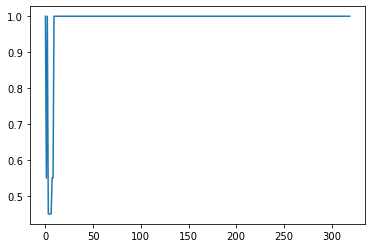

In [680]:
plt.plot(KAC_results)
plt.show()

In [677]:
net = Net().to(device)
optimizer = optim.SGD(net.parameters(), lr=1e-1)

with torch.no_grad():
    for i, p in enumerate(pcw):
        net.conv1.weight[i] = torch.nn.Parameter(torch.tensor(pcw[i])).to(device)
    
filtered_KAC_results=[]
for e in range(5):
    for i in range(0,len(KAC_train_x),batch_size):
        data = KAC_train_x[i:i+batch_size]
        X=torch.tensor(data).to(device, dtype=torch.float).view(-1,1,51,51)
        y=torch.tensor(KAC_train_y[i:i+batch_size]).to(device, dtype=torch.long)
        net.zero_grad()
        output = net(X)
        loss = F.nll_loss(output, y)
        loss.backward()
        optimizer.step()
        filtered_KAC_results.append(test(net))

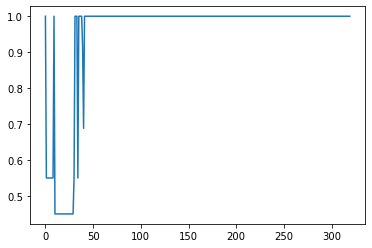

In [678]:
plt.plot(filtered_KAC_results)
plt.show()

In [ ]:
# Define testing procedure, for how many data points to get 90% acc